# Logistic Regression for Sentiment Analysis

Adapted from http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

<br>
<br>

## The IMDb Movie Review Dataset

In this section, we will train a simple logistic regression model to classify movie reviews from the 50k IMDb review dataset that has been collected by Maas et. al.

> AL Maas, RE Daly, PT Pham, D Huang, AY Ng, and C Potts. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Lin- guistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, June 2011. Association for Computational Linguistics

[Source: http://ai.stanford.edu/~amaas/data/sentiment/]

The dataset consists of 50,000 movie reviews from the original "train" and "test" subdirectories. The class labels are binary (1=positive and 0=negative) and contain 25,000 positive and 25,000 negative movie reviews, respectively.
For simplicity, I assembled the reviews in a single CSV file.


In [90]:
import re
import collections
import sys
import time
import numpy as np
import pandas as pd
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [91]:
# if you want to download the original file:
#df = pd.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/50k_imdb_movie_reviews.csv')
# otherwise load local file
df = pd.read_csv('shuffled_movie_data.csv')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


Let us shuffle the class labels.

In [92]:
df.head().values[0]

array(['In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and ric

In [93]:
## uncomment these lines if you have dowloaded the original file:
#np.random.seed(0)
#df = df.reindex(np.random.permutation(df.index))
#df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)

<br>
<br>

## Preprocessing Text Data

Now, let us define a simple `tokenizer` that splits the text into individual word tokens. Furthermore, we will use some simple regular expression to remove HTML markup and all non-letter characters but "emoticons," convert the text to lower case, remove stopwords, and apply the Porter stemming algorithm to convert the words into their root form.

In [94]:
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
#stop = stopwords.words('english')
#porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower())
    text = [w for w in text.split()]
    tokenized = [wordnet_lemmatizer.lemmatize(w) for w in text]
    return tokenized

Let's give it at try:

In [95]:
tokenizer('This :) is a <a> test! :-)</br>')


['this', 'is', 'a', 'test']

## Learning (SciKit)

First, we define a generator that returns the document body and the corresponding class label:

In [107]:
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

To conform that the `stream_docs` function fetches the documents as intended, let us execute the following code snippet before we implement the `get_minibatch` function:

In [108]:
#next(stream_docs(path='shuffled_movie_data.csv'))

After we confirmed that our `stream_docs` functions works, we will now implement a `get_minibatch` function to fetch a specified number (`size`) of documents:

In [109]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    for _ in range(size):
        text, label = next(doc_stream)
        docs.append(text)
        y.append(label)
    return docs, y

Next, we will make use of the "hashing trick" through scikit-learns [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) to create a bag-of-words model of our documents. Details of the bag-of-words model for document classification can be found at  [Naive Bayes and Text Classification I - Introduction and Theory](http://arxiv.org/abs/1410.5329).

In [110]:
#from sklearn.feature_extraction.text import HashingVectorizer
#vect = HashingVectorizer(decode_error='ignore', 
#                         n_features=2**21,
#                         preprocessor=None, 
#                         tokenizer=tokenizer)

# Exercise 1: define features based on word embeddings (pre-trained word2vec / Glove/Fastext emebddings can be used)
# Define suitable d dimension, and sequence length

In [139]:
doc_generator = stream_docs(path='shuffled_movie_data.csv')

In [141]:
def bag_words(gen, size):
    bag    = []
    for i, doc in enumerate(gen):
        bag += tokenizer(doc[0])
        sys.stdout.write('\r{:5.2f}%'.format(100*(i+1)/50000))
    sys.stdout.write('\rDone     \n\n')
    print('Bag Size: ', len(bag))
    count  = [['UNK', -1]]
    count += collections.Counter(bag).most_common(size - 1)
    
    count  = [(word, cnt) for word, cnt in count if cnt not in [0,1]]
    for element in count:
        if element[1] == 1:
            count.remove(element)
    dic    = {}
    for i, word in enumerate(count):
        dic[word[0]] = i
    
    return dic , dict(zip(dic.values(), dic.keys()))

In [142]:
dic, rev_dic = bag_words(doc_generator, 80000) #63069

Done     

Bag Size:  11772191


In [143]:
FEATURES = len(dic.keys())

In [144]:
#del doc_generator

print(FEATURES)
print(dic['UNK'])

56325
0


In [145]:
class OneHotEncoder:
    def __init__ (self, rev_dict):
        self.size = len(rev_dict.values())
        self.dict = rev_dict
        
    def __repr__ (self):
        return ('OneHotEncoder Class (Size = {})'.format(self.n))
        
    def getVector(self, word):
        vec = np.zeros((1, self.size))
        vec[0, self.dict[word]] = 1
        return vec

In [146]:
class DocToVec:
    """
        Convert a list of words to feature vectors:
        
        Arguments:
            
            n_features: number of features per vector, by default 6818.
            fn        : tokenizer function
    """
    
    def __init__(self, dictionary, tokenizer):
        self.encoder  = OneHotEncoder(dic) 
        self.dict     = dictionary
        self.features = self.encoder.size
        self.fn       = tokenizer
        
    def transform(self, DocList):
        """
            Transform an array of list of words to a matrix:

            Arguments:

                DocList: Array of list of reviews

            Returns:

                Matrix with feature vectors of each review.

        """
    
        n   = len(DocList)
        vec = np.zeros(shape=(n, self.features), dtype = np.uint8)
        
        total_time = 0
        for idx, strn in enumerate(DocList):
            start_time = time.time()
            rev_tok    = self.fn(strn)
            veci = np.zeros((1, self.features))
            for word in rev_tok:
                if word in self.dict:
                    veci += self.encoder.getVector(word)
            vec[idx] = veci
            if ((idx+1) % 500 == 0):
                elapsed  = time.time() - start_time
                total_time += elapsed
                total_time /= (idx+1/500)
                print('percent = {:4.1f}%, time estimated : {:3.1f} min'.format(100*(idx+1)/n, n*elapsed/60.0))
        return vec       

Using the [SGDClassifier]() from scikit-learn, we will can instanciate a logistic regression classifier that learns from the documents incrementally using stochastic gradient descent. 

In [147]:
vec = DocToVec(dic, tokenizer)

In [149]:
l = vec.transform([df.head().values[0][0]])

FirstReview = []
for i in range(FEATURES):
    if l[0][i] != 0:
        FirstReview.append((rev_dic[i], int(l[0][i])))

FirstReview.sort(key=lambda x: x[1])

FirstReview = FirstReview[::-1]
for i in range(10):
    print('{:20} : {:3} times'.format(FirstReview[i][0], FirstReview[i][1]))

the                  :  23 times
of                   :  12 times
in                   :  10 times
a                    :  10 times
and                  :   8 times
wa                   :   6 times
to                   :   6 times
murder               :   5 times
with                 :   4 times
is                   :   4 times


In [150]:
## Uncomment these lines if you don't save 'vec_data_X' and 'vec_data_y':
stream = stream_docs(path='shuffled_movie_data.csv')

X_train, y_train = get_minibatch(stream, size=50000)
y_train = np.asarray(y_train).reshape((-1, 1))

X_train = vec.transform(X_train)

np.save('vec_data_X', X_train)
np.save('vec_data_y', y_train)

percent =  1.0%, time estimated : 22.3 min
percent =  2.0%, time estimated : 7.7 min
percent =  3.0%, time estimated : 3.8 min
percent =  4.0%, time estimated : 5.0 min
percent =  5.0%, time estimated : 16.4 min
percent =  6.0%, time estimated : 11.5 min
percent =  7.0%, time estimated : 3.2 min
percent =  8.0%, time estimated : 6.7 min
percent =  9.0%, time estimated : 7.2 min
percent = 10.0%, time estimated : 5.5 min
percent = 11.0%, time estimated : 16.6 min
percent = 12.0%, time estimated : 7.4 min
percent = 13.0%, time estimated : 1.9 min
percent = 14.0%, time estimated : 5.9 min
percent = 15.0%, time estimated : 11.6 min
percent = 16.0%, time estimated : 16.3 min
percent = 17.0%, time estimated : 9.9 min
percent = 18.0%, time estimated : 7.6 min
percent = 19.0%, time estimated : 37.9 min
percent = 20.0%, time estimated : 2.1 min
percent = 21.0%, time estimated : 12.0 min
percent = 22.0%, time estimated : 3.1 min
percent = 23.0%, time estimated : 18.2 min
percent = 24.0%, time est

In [134]:
#from sklearn.linear_model import SGDClassifier
#clf = SGDClassifier(loss='log', random_state=1, n_iter=1)
#doc_stream = stream_docs(path='shuffled_movie_data.csv')
# Exercise 2: Define at least a Three layer neural network. Define its structure (number of hidden neurons, etc)
# Define a nonlinear function for hidden layers.
# Define a suitable loss function for binary classification
# Implement the backpropagation algorithm for this structure
# Do not use Keras / Tensorflow /PyTorch etc. libraries
# Train the model using SGD

In [151]:
X_train = np.load('vec_data_X.npy')
y_train = np.load('vec_data_y.npy')

In [152]:
from sklearn.preprocessing import normalize

print(X_train.shape)
print(y_train.shape)

(50000, 56325)
(50000, 1)


In [153]:
X_data_train = X_train[:30000]
y_data_train = y_train[:30000]

X_data_valid = X_train[30000:40000]
y_data_valid = y_train[30000:40000]

X_data_test  = X_train[40000:]
y_data_test  = y_train[40000:]

print(X_data_train.shape, y_data_train.shape)
print(X_data_valid.shape, y_data_valid.shape)
print(X_data_test.shape, y_data_test.shape)

(30000, 56325) (30000, 1)
(10000, 56325) (10000, 1)
(10000, 56325) (10000, 1)


In [154]:
class log_regr:
    """
        Logistic Regression with L1 and L2 regularization
        
        Arguments:
                
                W       : Weights
                b       : Bias
                alpha   : Learning Rate
                l1_coef : Lambda 1
                l2_coef : Lambda 2
            
    """
    
    def __init__ (self, W, b, alpha, lambda_1, lambda_2):
        self.W       = W
        self.b       = b
        self.alpha   = alpha
        self.l1_coef = lambda_1
        self.l2_coef = lambda_2
        
    def sigmoid(self,z):
        """
            Activation function
            
            Arguments:  
                z : W*X + b
                
            Returns:
                sigmoid function of z.
                
        """
        return 1 / (1 + np.exp(-z))
    
    def pred(self, X):
        """
            Given a X matrix as a input we return the prediction for
            W and b.
            
            Args:
                X : Matrix of features vectors for each review
            
            Returns:
                Prediction without a threshold
        """
        
        return self.sigmoid(np.matmul(X, self.W) + self.b)
    
    def acc(self, X, y):
        """
            Accuracy of a input and label
            
            Args:
                X: Matrix of features vectors for each review
                y: Labels of each Matrix
            
            Returns:
                A number between 0 and 1.0
        """
        pred_lim = self.pred(X) > 0.5
        return np.mean(pred_lim == y)
    
    def cross_entropy(self, X, y):
        """
            Cost function
            
                Cost = - [y * log(sigma(W*X + b)) + (1 - y) * log(1 - sigma(W*X + b))] 
                         + 0.5 * l2_ratio * ||w||^2_2 
                         + l1_ratio * ||w||_1 
            
            Args:
                X: Matrix of features vectors for each review
                y: Labels of each Matrix
                
            Returns:
                Cost using L1 and L2 regularizations 
                
        """
        return - 0.5 * np.mean(np.multiply(y  , np.log(self.pred(X)     + 1e-8))
                       + np.multiply(1-y, np.log(1 - self.pred(X) + 1e-8))) + \
                    0.5 * self.l2_coef * np.mean(np.square(self.W)) + \
                          self.l1_coef * np.mean(np.abs(self.W))
    
    def fit(self, X, y):
        """
            function to minimize the Cost
            
            Args:
                X: Matrix of features vectors for each review
                y: Labels of each Matrix
            
        """
        
        self.W = self.W - self.alpha * np.matmul(np.transpose(X), self.pred(X) - y) / X.shape[0] - \
                          self.alpha * self.l2_coef * self.W - \
                          self.alpha * self.l1_coef * np.multiply(self.W, 1 / np.abs(self.W))
        self.b = self.b - self.alpha * np.mean(self.pred(X) - y)  

In [181]:
FEATURES = X_data_train.shape[1]
W_ = np.random.normal(0, 0.001, (FEATURES,1))
b_ = 0.0
lr = 0.2

# lr = 0.2, l1,l2=1e-5, batch 1= 100, batch2 = 100, epoch=5 :: All Test Good!

lambda1 = 1e-4
lambda2 = 1e-4

regr  = log_regr(W_, b_, lr, lambda1, lambda2)

BATCH  = 100
BATCH2 = 100
STEP   = 1
fmt    = '{:3d} epoch : {:5.2f} docs/s, loss_train = {:5.4f}, loss_val = {:5.4f}, acc_train = {:4.3f}, acc_test = {:4.3f}'
NEPOCH = 20

train_epoch     = []
valid_epoch     = []
acc_train_epoch = []
acc_test_epoch  = []

for i in range(NEPOCH):
    loss_t  = 0.0
    n_batch = X_data_train.shape[0]/BATCH
    st = time.time()
    for i_batch in range(0,X_data_train.shape[0], BATCH):
        X_batch = X_data_train[i_batch:i_batch+BATCH]
        y_batch = y_data_train[i_batch:i_batch+BATCH]
        regr.fit(X_batch , y_batch)
        loss_tmp = regr.cross_entropy(X_batch, y_batch)
        loss_t  += loss_tmp
        #if i_batch  % 10000 == 0:
        #    print('-> i_batch : [{:6d} - {:6d}], loss_temp = {:5.4f}'.format(i_batch, i_batch + BATCH,loss_tmp))
    dt   = time.time() - st
        
    if (i+1)%STEP == 0:
        train_epoch.append(loss_t/n_batch)
        acc_train = 0
        for i_batch in range(0,X_data_train.shape[0], BATCH):
            X_batch_   = X_data_train[i_batch:i_batch+BATCH]
            y_batch_   = y_data_train[i_batch:i_batch+BATCH]
            acc_train += regr.acc(X_batch_, y_batch_)
        
        acc_train_epoch.append(acc_train/n_batch)
        loss_valid = 0
        acc_test   = 0
        
        v_batch = X_data_valid.shape[0]/BATCH2
        for i_batch in range(0,X_data_valid.shape[0], BATCH2):
            X_batch_v = X_data_valid[i_batch:i_batch+BATCH2]
            y_batch_v = y_data_valid[i_batch:i_batch+BATCH2]
            
            loss_valid += regr.cross_entropy(X_batch_v, y_batch_v)
            
            X_batch_t = X_data_test[i_batch:i_batch+BATCH2]
            y_batch_t = y_data_test[i_batch:i_batch+BATCH2]
            
            acc_test += regr.acc(X_batch_t, y_batch_t)
        valid_epoch.append(loss_valid/v_batch)
        acc_test_epoch.append(acc_test/v_batch)
        print(fmt.format((i+1), (X_data_train.shape[0])/dt,
                                      loss_t/n_batch, 
                                      loss_valid/v_batch,
                                      acc_train/n_batch,
                                      acc_test/v_batch))


	  1 epoch : 1337.80 docs/s, loss_train = 0.7775, loss_val = 0.2995, acc_train = 0.777, acc_test = 0.766


	  2 epoch : 1241.75 docs/s, loss_train = 0.4523, loss_val = 0.2371, acc_train = 0.820, acc_test = 0.813


	  3 epoch : 1304.16 docs/s, loss_train = 0.3522, loss_val = 0.1974, acc_train = 0.854, acc_test = 0.844


	  4 epoch : 1395.27 docs/s, loss_train = 0.3144, loss_val = 0.1901, acc_train = 0.863, acc_test = 0.849


	  5 epoch : 1418.55 docs/s, loss_train = 0.2873, loss_val = 0.1836, acc_train = 0.869, acc_test = 0.855


	  6 epoch : 1442.07 docs/s, loss_train = 0.2651, loss_val = 0.1755, acc_train = 0.875, acc_test = 0.859


	  7 epoch : 1358.78 docs/s, loss_train = 0.2457, loss_val = 0.1675, acc_train = 0.881, acc_test = 0.863


	  8 epoch : 1458.53 docs/s, loss_train = 0.2288, loss_val = 0.1634, acc_train = 0.885, acc_test = 0.867


	  9 epoch : 1463.38 docs/s, loss_train = 0.2130, loss_val = 0.1607, acc_train = 0.888, acc_test = 0.869


	 10 epoch : 1436.07 docs/s, loss_tr

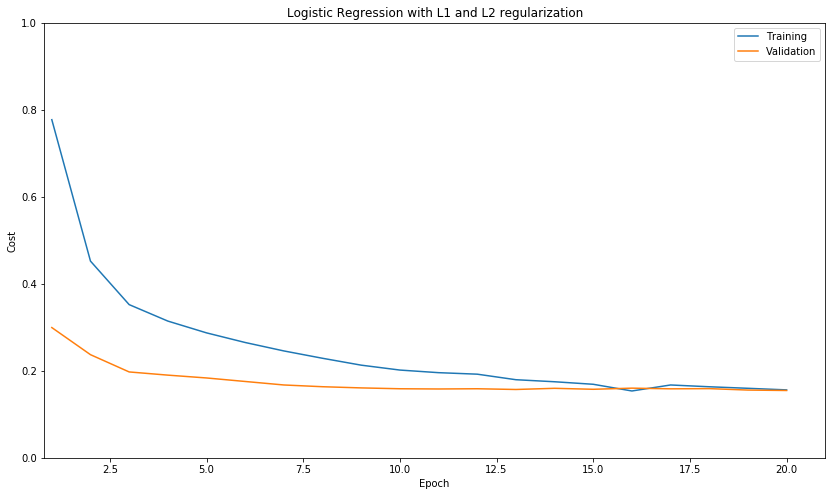

In [184]:
import matplotlib.pyplot as plt

ep = np.arange(1, NEPOCH + 1, 1)

fig, ax = plt.subplots(figsize=(14, 8))
l1 , l2   = ax.plot(ep, train_epoch, ep, valid_epoch)
ax.set(xlabel='Epoch', ylabel='Cost', title='Logistic Regression with L1 and L2 regularization')
ax.axis([0.8, NEPOCH + 1, 0.0, 1])
plt.legend([l1, l2],["Training","Validation"])
plt.show()

Depending on your machine, it will take about 2-3 minutes to stream the documents and learn the weights for the logistic regression model to classify "new" movie reviews. Executing the preceding code, we used the first 45,000 movie reviews to train the classifier, which means that we have 5,000 reviews left for testing:

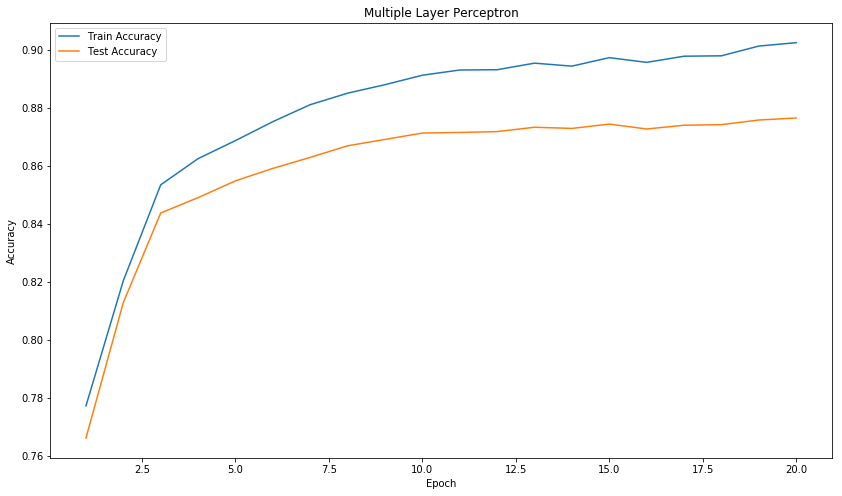

In [185]:
fig, ax = plt.subplots(figsize=(14, 8))

l3, l4  = ax.plot(ep, acc_train_epoch, ep, acc_test_epoch)
ax.set(xlabel='Epoch', ylabel='Accuracy', title='Multiple Layer Perceptron')

plt.legend([l3, l4],["Train Accuracy", "Test Accuracy"])
plt.show()

In [186]:
#Exercise 3: compare  with your Neural Network

example = ['I loved this movie']
X = vec.transform(example)
print(regr.pred(X))
regr.pred(X)[0][0] > 0.5

[[0.63770313]]


True

In [187]:
example = ['I hate this movie']
X = vec.transform(example)
print(regr.pred(X))
regr.pred(X)[0][0] > 0.5

[[0.50567599]]


True

In [188]:
example = ["I don't love this movie"]
X = vec.transform(example)
print(regr.pred(X))
regr.pred(X)[0][0] > 0.5

[[0.52659398]]


True

In [189]:
example = ["I do not love this movie"]
X = vec.transform(example)
print(regr.pred(X))
regr.pred(X)[0][0] > 0.5

[[0.51316028]]


True

I think that the predictive performance, an accuracy of ~87%, is quite "reasonable" given that we "only" used the default parameters and didn't do any hyperparameter optimization. 

After we estimated the model perfomance, let us use those last 5,000 test samples to update our model.

<br>
<br>

# Model Persistence

In the previous section, we successfully trained a model to predict the sentiment of a movie review. Unfortunately, if we'd close this IPython notebook at this point, we'd have to go through the whole learning process again and again if we'd want to make a prediction on "new data."

So, to reuse this model, we could use the [`pickle`](https://docs.python.org/3.5/library/pickle.html) module to "serialize a Python object structure". Or even better, we could use the [`joblib`](https://pypi.python.org/pypi/joblib) library, which handles large NumPy arrays more efficiently.

To install:
conda install -c anaconda joblib

In [18]:
#import joblib
#import os
#if not os.path.exists('./pkl_objects'):
#    os.mkdir('./pkl_objects')
    
#joblib.dump(vect, './vectorizer.pkl')
#joblib.dump(clf, './clf.pkl')

Using the code above, we "pickled" the `HashingVectorizer` and the `SGDClassifier` so that we can re-use those objects later. However, `pickle` and `joblib` have a known issue with `pickling` objects or functions from a `__main__` block and we'd get an `AttributeError: Can't get attribute [x] on <module '__main__'>` if we'd unpickle it later. Thus, to pickle the `tokenizer` function, we can write it to a file and import it to get the `namespace` "right".

In [19]:
#%%writefile tokenizer.py
#from nltk.stem.porter import PorterStemmer
#import re
#from nltk.corpus import stopwords

#stop = stopwords.words('english')
#porter = PorterStemmer()

#def tokenizer(text):
#    text = re.sub('<[^>]*>', '', text)
#    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
#    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
#    text = [w for w in text.split() if w not in stop]
#    tokenized = [porter.stem(w) for w in text]
#    return text

In [20]:
#from tokenizer import tokenizer
#joblib.dump(tokenizer, './tokenizer.pkl')

Now, let us restart this IPython notebook and check if the we can load our serialized objects:

In [21]:
#import joblib
#tokenizer = joblib.load('./tokenizer.pkl')
#vect = joblib.load('./vectorizer.pkl')
#clf = joblib.load('./clf.pkl')

After loading the `tokenizer`, `HashingVectorizer`, and the tranined logistic regression model, we can use it to make predictions on new data, which can be useful, for example, if we'd want to embed our classifier into a web application -- a topic for another IPython notebook.

In [22]:
#example = ['I did not like this movie']
#X = vect.transform(example)
#clf.predict(X)

In [23]:
#example = ['I loved this movie']
#X = vect.transform(example)
#clf.predict(X)